How well do our observations at 0.33$R_{26}$ / 0.4$R_{26}$ match MaNGA's observations at the same radius?  And how well do our velocities observed at these radii reproduce the asymptotic rotational velocity?

In [1]:
import numpy as np
import numpy.ma as ma

from astropy.io import fits
from astropy.table import Table
from astropy.coordinates import SkyCoord
import astropy.constants as const
import astropy.units as u
from astropy.io import fits
from astropy import wcs

import scipy.stats as stats

import os

import sys
sys.path.insert(1, '/global/homes/k/kadglass/RotationCurves/spirals/')
from dark_matter_mass_v1 import rot_fit_BB

import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
mpl.rc('font', size=12)

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

In [3]:
h = 1
H0 = 100*h*u.km/u.s/u.Mpc

c = const.c.to('km/s')

q0 = 0.2

MANGA_SPAXEL_SIZE = 0.5*u.arcsec

# Import data

In [4]:
#file_prefix = '/global/project/' # Cori
file_prefix = '/global/cfs/' # Perlmutter

## DESI

In [5]:
tf_targets = Table.read(file_prefix + 'projectdirs/desi/science/td/pv/desi_pv_tf_fuji_healpix.fits')

## SGA

In [6]:
SGA = Table.read('/global/cfs/cdirs/cosmo/data/sga/2020/SGA-2020.fits', 'ELLIPSE')

In [7]:
SGA_dict = {}

for i in range(len(SGA)):
    
    SGA_dict[SGA['SGA_ID'][i]] = i

## SDSS MaNGA cross-match file

Made by Grace Chiodo in Summer 2021, using SDSS MaNGA DR15.

In [8]:
SGA_MaNGA = Table.read('MaNGA_DESI_galaxies_08042021.txt', format='ascii.commented_header')

SGA_MaNGA[:5]

MaNGA_plate,MaNGA_IFU,sga_id,BA,PA,plateifu
int64,int64,int64,float64,float64,str10
7968,3702,97758,0.3215293288230896,159.22218322753906,7968-3702
8479,6101,433955,0.32715362310409546,54.33457565307617,8479-6101
8479,6102,487085,0.5813088417053223,1.3182913064956665,8479-6102
8480,6103,487085,0.5813088417053223,1.3182913064956665,8480-6103
8481,12705,810971,0.268082857131958,56.5462760925293,8481-12705


## SDSS MaNGA best-fits

From Douglass & Demina (2022)

In [9]:
#MaNGA_fits = Table.read('DESI_vel_map_results_BB_smooth_lt_1p85_v2.txt', 
MaNGA_fits = Table.read('DRP-master_file_vflag_BB_smooth1p85_mapFit_N2O2_HIdr2_morph_SK_H2_noWords_v7.txt', 
                        format='ascii.commented_header')

# Compare DESI's observed rotational velocities at 0.33$R_{26}$ with $V_{max}$ from the best-fit to MaNGA

## 1) Calculate the rotational velocities for the DESI galaxies

### Separate the fuji data into center and off-center observations

In [10]:
def firstdigit(n):
    """
    Return the first digit of a number.
    
    Parameters
    ----------
    n : int, float, or ndarray
        Number or list of numbers.
    
    Returns
    -------
    digit : int
        First digit of the number.
    """
    
    digit = np.trunc(n * 10**(-np.trunc(np.log10(n)))).astype(int)
    
    return digit

In [11]:
first_digits = firstdigit(tf_targets['TARGETID'])

centers = tf_targets[first_digits == 3]
axis = tf_targets[first_digits != 3]

/tmp/ipykernel_169048/917620242.py:16: RuntimeWarning: invalid value encountered in log10
  digit = np.trunc(n * 10**(-np.trunc(np.log10(n)))).astype(int)


### Clean the fuji center observations

Only keep those with
 * DELTACHI2 > 25
 * ZWARN == 0

In [12]:
good_centers = centers[(centers['DELTACHI2'] > 25) & (centers['ZWARN'] == 0)]

### If an SGA galaxy has at least one observation at its center, set the redshift of that galaxy

In [13]:
SGA['Z_DESI'] = np.nan
SGA['ZERR_DESI'] = np.nan

for sga_id in np.unique(good_centers['SGA_ID']):
    
    # Find the row in SGA for this galaxy
    SGA_idx = SGA_dict[sga_id]
    
    # Set the redshift of this galaxy to be the average redshift of all good center observations
    SGA['Z_DESI'][SGA_idx] = np.mean(good_centers['Z'][good_centers['SGA_ID'] == sga_id])
    SGA['ZERR_DESI'][SGA_idx] = np.mean(good_centers['ZERR'][good_centers['SGA_ID'] == sga_id]**2)/np.sum(good_centers['SGA_ID'] == sga_id)

In [14]:
SGA_MaNGA['Z_DESI'] = np.nan
SGA_MaNGA['ZERR_DESI'] = np.nan

for i in range(len(SGA_MaNGA)):
    
    # Find the row in SGA for this galaxy
    SGA_idx = SGA_dict[SGA_MaNGA['sga_id'][i]]
    
    # Set the redshift of this galaxy
    SGA_MaNGA['Z_DESI'][i] = SGA['Z_DESI'][SGA_idx]
    SGA_MaNGA['ZERR_DESI'][i] = SGA['ZERR_DESI'][SGA_idx]

### Calculate the rotational velocity

In [15]:
axis['SKY_FIBER_DIST'] = 0.
axis['SKY_FIBER_DIST_R26'] = 0.
axis['V_ROT'] = np.nan
axis['V_ROT_ERR'] = np.nan


# For each SGA galaxy that has at least one center observation, calculate the 
# distance for all of that galaxy's targets
for sga_gal in np.unique(centers['SGA_ID']):
    
    # Identify all galaxy targets on this galaxy
    obs_idx = axis['SGA_ID'] == sga_gal
    
    # Find galaxy index in SGA catalog
    sga_idx = SGA_dict[sga_gal]
    
    #---------------------------------------------------------------------------
    # Calculate distance between each observation and the center
    #---------------------------------------------------------------------------
    center_coords = SkyCoord(ra=SGA['RA'][sga_idx], 
                             dec=SGA['DEC'][sga_idx], 
                             unit=u.degree)
    target_coords = SkyCoord(ra=axis['RA'][obs_idx], 
                             dec=axis['DEC'][obs_idx], 
                             unit=u.degree)
    
    sep2d = target_coords.separation(center_coords)
    
    axis['SKY_FIBER_DIST'][obs_idx] = sep2d.to('radian')
    axis['SKY_FIBER_DIST_R26'][obs_idx] = 2*sep2d.to('arcmin')/(SGA['D26'][sga_idx]*u.arcmin)
    #---------------------------------------------------------------------------
    
    
    #---------------------------------------------------------------------------
    # Calculate rotational velocity
    #---------------------------------------------------------------------------
    # Use the average redshift of all center observations for the systemic velocity
    z_center = np.mean(SGA['Z_DESI'][sga_idx])
    z_err_center2 = SGA['ZERR_DESI'][sga_idx]**2

    # Calculate rotational velocity for all observations of the galaxy
    axis['V_ROT'][obs_idx] = c*(axis['Z'][obs_idx] - z_center)
    axis['V_ROT_ERR'][obs_idx] = c*np.sqrt(axis['ZERR'][obs_idx]**2 + z_err_center2)
    #---------------------------------------------------------------------------
    
    
    #---------------------------------------------------------------------------
    # Correct rotational velocities for inclination angle
    #---------------------------------------------------------------------------
    cosi2 = (SGA['BA'][sga_idx]**2 - q0**2)/(1 - q0**2)
    
    # Galaxies with b/a < q0
    if cosi2 < 0:
        cosi2 = 0
    
    axis['V_ROT'][obs_idx] /= np.sin(np.arccos(np.sqrt(cosi2)))
    #---------------------------------------------------------------------------

/tmp/ipykernel_169048/2809901910.py:56: RuntimeWarning: divide by zero encountered in true_divide
  axis['V_ROT'][obs_idx] /= np.sin(np.arccos(np.sqrt(cosi2)))


### Just keep those velocities measured at 0.33$R_{26}$

In [16]:
axis_0p3 = axis[(axis['SKY_FIBER_DIST_R26'] > 0.3) & (axis['SKY_FIBER_DIST_R26'] < 0.4)]

### Remove "bad" galaxies

Those with
* $V > 1000$ km/s

In [17]:
axis_0p3_good = axis_0p3[np.abs(axis_0p3['V_ROT']) < 1000]

### Add these velocities to the SDSS MaNGA - SGA cross-match file

In [18]:
SGA_MaNGA['V_0p33R26'] = np.nan
SGA_MaNGA['V_0p33R26_ERR'] = np.nan

SGA_MaNGA['SKY_FIBER_DIST'] = np.nan

weights = 1./(axis_0p3_good['V_ROT_ERR']**2)

for i in range(len(SGA_MaNGA)):
    
    # Does this galaxy have any observations?
    i_obs = axis_0p3_good['SGA_ID'] == SGA_MaNGA['sga_id'][i]
    
    if np.sum(i_obs) > 0:
        
        # Average all velocities at this radius
        SGA_MaNGA['V_0p33R26'][i] = np.average(np.abs(axis_0p3_good['V_ROT'][i_obs]), 
                                               weights=weights[i_obs])
        SGA_MaNGA['V_0p33R26_ERR'][i] = np.sqrt(1./np.sum(weights[i_obs]))
        
        # Copy over the distance from the center for this observation
        SGA_MaNGA['SKY_FIBER_DIST'][i] = np.average(axis_0p3_good['SKY_FIBER_DIST'][i_obs])

In [19]:
SGA_MaNGA[np.isfinite(SGA_MaNGA['V_0p33R26'])].show_in_notebook()

idx,MaNGA_plate,MaNGA_IFU,sga_id,BA,PA,plateifu,Z_DESI,ZERR_DESI,V_0p33R26,V_0p33R26_ERR,SKY_FIBER_DIST
0,8479,6102,487085,0.5813088417053223,1.3182913064956665,8479-6102,0.0781894572006586,4.128757013734015e-10,223.95494076075573,8.795513663749514,3.229689275391676e-05
1,8480,6103,487085,0.5813088417053223,1.3182913064956665,8480-6103,0.0781894572006586,4.128757013734015e-10,223.95494076075573,8.795513663749514,3.229689275391676e-05
2,8481,12705,810971,0.268082857131958,56.5462760925293,8481-12705,0.0429954501267412,1.4271031257383006e-11,143.9510078418774,2.215518265835735,3.892200047028368e-05
3,8484,3701,302062,0.6225041747093201,119.090087890625,8484-3701,0.0330699912027746,1.6979658498427393e-11,109.17612316124635,2.1124446051803405,5.0312462183783855e-05
4,8547,6102,925354,0.6025776267051697,146.05860900878906,8547-6102,0.0304755987259764,6.889141919295922e-12,205.77258114621176,1.5235238718905617,5.184274505357124e-05
5,8547,6103,171058,0.5511276125907898,3.9989326000213623,8547-6103,0.0424646075925578,5.42803872635667e-11,138.28308158423158,0.4916285418325515,3.0965137475783706e-05
6,8555,12703,127268,0.2092917561531067,143.2239532470703,8555-12703,0.058413206227691,4.1767742731339365e-10,210.96779881214266,2.332334252430736,4.551138894709631e-05
7,8555,1902,575284,0.6609105467796326,106.39098358154297,8555-1902,0.0315230893119107,4.800313228036706e-10,137.07386885858102,4.085461504059483,2.6790624709163474e-05
8,8555,9102,1285122,0.7685890793800354,107.45079040527344,8555-9102,0.0459386508726562,1.1505989957506619e-10,162.57738944564244,1.358729053158345,2.5798182956148833e-05
9,8600,1901,186915,0.7746372222900391,129.28488159179688,8600-1901,0.0252226335677048,9.586277305922652e-13,166.8309402755933,1.5433379347652003,2.8018559064157407e-05


Based on visual inspection of my fits to the MaNGA DR15 data for these galaxies (from Douglass & Demina, 2022), I determined that
* Galaxies that need to be refit: **8932-3701** and **9037-9102**
* Galaxies that are not spirals but have fits: 8931-1902, 8931-3702, 8932-12702, 8932-3703, 8935-9101, 8950-3702, and 8950-9102
* Galaxies that do not have fits (either no data or are not spirals): 8479-6102, 8480-6103, 8931-3702, 8932-12705, 8932-6102, 8949-12705, 8949-9102, 9051-6104, 9876-6102

### Add the MaNGA best-fit values to the table

In [20]:
SGA_MaNGA['Vmax_map'] = np.nan
SGA_MaNGA['Vmax_err_map'] = np.nan
SGA_MaNGA['Rturn_map'] = np.nan
SGA_MaNGA['alpha_map'] = np.nan

SGA_MaNGA['ba_map'] = np.nan
SGA_MaNGA['ba_NSA'] = np.nan

for i in range(len(SGA_MaNGA)):
    
    gal_id = str(SGA_MaNGA['MaNGA_plate'][i]) + '-' + str(SGA_MaNGA['MaNGA_IFU'][i])
    
    # Find galaxy row in MaNGA fits table
    plate_bool = MaNGA_fits['MaNGA_plate'] == SGA_MaNGA['MaNGA_plate'][i]
    ifu_bool = MaNGA_fits['MaNGA_IFU'] == SGA_MaNGA['MaNGA_IFU'][i]
    
    i_fit = plate_bool & ifu_bool
    
    # Copy best-fit parameter values from fit table to galaxy table
    if (np.sum(i_fit) > 0) and (gal_id not in ['8931-1902', '8931-3702', '8932-12702', '8932-3703', '8935-9101', '8950-3702', '8950-9102']):
        SGA_MaNGA['Vmax_map'][i] = MaNGA_fits['Vmax_map'][i_fit]
        SGA_MaNGA['Vmax_err_map'][i] = MaNGA_fits['Vmax_err_map'][i_fit]
        SGA_MaNGA['Rturn_map'][i] = MaNGA_fits['Rturn_map'][i_fit]
        SGA_MaNGA['alpha_map'][i] = MaNGA_fits['alpha_map'][i_fit]
        
        SGA_MaNGA['ba_map'][i] = MaNGA_fits['ba_map'][i_fit]
        SGA_MaNGA['ba_NSA'][i] = MaNGA_fits['NSA_ba'][i_fit]
        
# Flip all -99 values to NaN
SGA_MaNGA['Vmax_map'][SGA_MaNGA['Vmax_map'] == -99] = np.nan

In [21]:
np.sum(np.isfinite(SGA_MaNGA['Vmax_map']) & np.isfinite(SGA_MaNGA['V_0p33R26']))

34

### Plot

Text(0.5, 0, '$V(0.33R_{26})$ [km/s]')

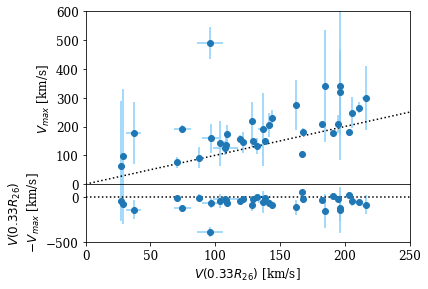

In [22]:
fig = plt.figure()

frame1 = fig.add_axes((0.2, 0.35, 0.75, 0.6))

plt.errorbar(SGA_MaNGA['V_0p33R26'], SGA_MaNGA['Vmax_map'], 
             yerr=SGA_MaNGA['Vmax_err_map'], 
             xerr=SGA_MaNGA['V_0p33R26_ERR'], 
             fmt='o', 
             ecolor='lightskyblue')
plt.plot([0, 1000], [0, 1000], 'k:')

plt.ylim(0, 600)
plt.xlim(0, 250)

plt.ylabel('$V_{max}$ [km/s]')

frame1.axes.get_xaxis().set_visible(False)


frame2 = fig.add_axes((0.2, 0.15, 0.75, 0.2))

plt.errorbar(SGA_MaNGA['V_0p33R26'], SGA_MaNGA['V_0p33R26'] - SGA_MaNGA['Vmax_map'], 
             xerr=SGA_MaNGA['V_0p33R26_ERR'], 
             yerr=np.sqrt(SGA_MaNGA['V_0p33R26_ERR']**2 + SGA_MaNGA['Vmax_err_map']**2), 
             fmt='o', 
             ecolor='lightskyblue')
plt.hlines(0, 0, 250, linestyles='dotted', colors='k')

plt.xlim(0, 250)
plt.ylim(-500, 150)

plt.ylabel('$V(0.33R_{26})$\n $- V_{max}$ [km/s]')        
plt.xlabel('$V(0.33R_{26})$ [km/s]')

#plt.savefig('../Figures/SV/fuji_MaNGA-Vmax_comparison.eps', dpi=300);

#### Save figure data to file for DESI publication

In [23]:
plot_v033 = fits.Column(name='DESI_V', array=SGA_MaNGA['V_0p33R26'], format='E', unit='km/s')
plot_v033_sigma = fits.Column(name='DESI_Verr', array=SGA_MaNGA['V_0p33R26_ERR'], format='E', unit='km/s')

plot_vmax = fits.Column(name='MaNGA_Vmax', array=SGA_MaNGA['Vmax_map'], format='E', unit='km/s')
plot_vmax_sigma = fits.Column(name='MaNGA_Vmax_err', array=SGA_MaNGA['Vmax_err_map'], format='E', unit='km/s')

Text(0, 0.5, 'Number of galaxies')

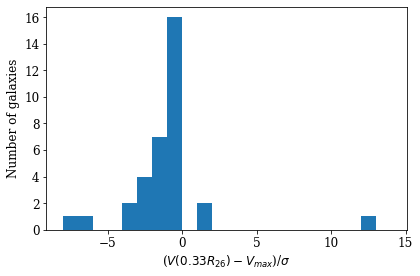

In [24]:
plt.figure(tight_layout=True)

plt.hist((SGA_MaNGA['V_0p33R26'] - SGA_MaNGA['Vmax_map'])/np.sqrt(SGA_MaNGA['V_0p33R26_ERR']**2 + SGA_MaNGA['Vmax_err_map']**2), 
         #bins=np.arange(-500, 100, 50), 
         bins=np.arange(-8, 15, 1),
         #histtype='step', 
         #linewidth=3
        )

#plt.xlabel('($V(0.33R_{26}) - V_{max}$) [km/s]')
plt.xlabel('($V(0.33R_{26}) - V_{max}$)/$\sigma$')
plt.ylabel('Number of galaxies')

#plt.savefig('../Figures/SV/fuji_MaNGA_Vmax_pull.png', dpi=300);

# Compare DESI's observed rotational velocities at 0.33$R_{26}$ with $V(0.33R_{26})$ from the best-fit to MaNGA

## 1) Convert $R_{26}$ to kpc for each galaxy

In [25]:
dist_to_galaxy = SGA_MaNGA['Z_DESI']*c/H0

R26_kpc = dist_to_galaxy.to('kpc')*np.tan(SGA_MaNGA['SKY_FIBER_DIST'])

## 2) Compute $V(0.33R_{26})$ based on the best-fits

In [26]:
SGA_MaNGA['Vfit_0p33R26'] = rot_fit_BB(R26_kpc.data, [SGA_MaNGA['Vmax_map'], SGA_MaNGA['Rturn_map'], SGA_MaNGA['alpha_map']])

### Compute the uncertainty in the velocity at this location

In [27]:
SGA_MaNGA['Vfit_0p33R26_err'] = np.nan

for i in range(len(SGA_MaNGA)):
    
    if np.isfinite(SGA_MaNGA['Vmax_map'][i]) and np.isfinite(SGA_MaNGA['V_0p33R26'][i]):
        
        gal_ID = str(SGA_MaNGA['MaNGA_plate'][i]) + '-' + str(SGA_MaNGA['MaNGA_IFU'][i])

        try:
            Hessian = np.load('DRP_map_Hessians/' + gal_ID + '_Hessian.npy')
            hess_inv = 2*np.linalg.inv(Hessian)

            N_samples = 10000

            random_sample = np.random.multivariate_normal(mean=[SGA_MaNGA['Vmax_map'][i], 
                                                                SGA_MaNGA['Rturn_map'][i], 
                                                                SGA_MaNGA['alpha_map'][i]], 
                                                          cov=hess_inv[-3:,-3:], 
                                                          size=N_samples)

            # Remove bad samples (those with negative values for any of the parameters)
            is_good_random = (random_sample[:,0] > 0) & (random_sample[:,1] > 0) & (random_sample[:,2] > 0)
            good_randoms = random_sample[is_good_random, :]

            # Calculate values of curve at this location
            y_sample = rot_fit_BB(R26_kpc[i].value, [good_randoms[:,0], 
                                                     good_randoms[:,1], 
                                                     good_randoms[:,2]])

            SGA_MaNGA['Vfit_0p33R26_err'][i] = np.std(y_sample, axis=0)
        except (FileNotFoundError, np.linalg.LinAlgError) as error:
            print(gal_ID, error)

/tmp/ipykernel_169048/3833718814.py:15: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[SGA_MaNGA['Vmax_map'][i],
/global/homes/k/kadglass/RotationCurves/spirals/dark_matter_mass_v1.py:74: RuntimeWarning: overflow encountered in power
  v = v_max * (np.abs(depro_radius) / (r_turn**alpha + np.abs(depro_radius)**alpha)**(1/alpha))


## 3) Plot

Text(0, 0.5, '$\\Delta V(0.33R_{26})$ [km/s]\n (DESI - MaNGA fit)')

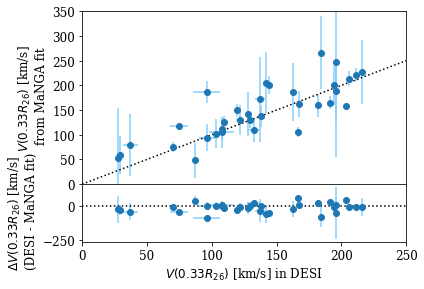

In [28]:
fig = plt.figure()

frame1 = fig.add_axes((0.2, 0.35, 0.75, 0.6))

plt.errorbar(SGA_MaNGA['V_0p33R26'], SGA_MaNGA['Vfit_0p33R26'], 
             yerr=SGA_MaNGA['Vfit_0p33R26_err'], 
             xerr=SGA_MaNGA['V_0p33R26_ERR'], 
             fmt='o', 
             ecolor='lightskyblue')
plt.plot([0, 1000], [0, 1000], 'k:')

plt.ylim(0, 350)
plt.xlim(0, 250)

plt.ylabel('$V(0.33R_{26})$ [km/s]\n from MaNGA fit')

frame1.axes.get_xaxis().set_visible(False)


frame2 = fig.add_axes((0.2, 0.15, 0.75, 0.2))

plt.errorbar(SGA_MaNGA['V_0p33R26'], SGA_MaNGA['V_0p33R26'] - SGA_MaNGA['Vfit_0p33R26'], 
             xerr=SGA_MaNGA['V_0p33R26_ERR'], 
             yerr=np.sqrt(SGA_MaNGA['V_0p33R26_ERR']**2 + SGA_MaNGA['Vfit_0p33R26_err']**2), 
             fmt='o', 
             ecolor='lightskyblue')
plt.hlines(0, 0, 250, linestyles='dotted', colors='k')

plt.xlim(0, 250)

plt.xlabel('$V(0.33R_{26})$ [km/s] in DESI')
plt.ylabel('$\Delta V(0.33R_{26})$ [km/s]\n (DESI - MaNGA fit)')

#plt.savefig('../Figures/SV/fuji_MaNGA-V0p33_comparison.eps', dpi=300);

#### Write plot data to file for DESI publication

In [31]:
plot_v033_fit = fits.Column(name='MaNGA_Vfit', array=SGA_MaNGA['Vfit_0p33R26'], format='E', unit='km/s')
plot_v033_fit_sigma = fits.Column(name='MaNGA_Vfit_err', array=SGA_MaNGA['Vfit_0p33R26_err'], format='E', unit='km/s')

In [32]:
plot_table = fits.BinTableHDU.from_columns([plot_v033, plot_v033_sigma, plot_v033_fit, plot_v033_fit_sigma, plot_vmax, plot_vmax_sigma])

plot_table.writeto('publication_data/figs10-11.fits')

### Pull distribution

In [49]:
diff_norm = (SGA_MaNGA['V_0p33R26'] - SGA_MaNGA['Vfit_0p33R26'])/np.sqrt(SGA_MaNGA['V_0p33R26_ERR']**2 + SGA_MaNGA['Vfit_0p33R26_err']**2)

avg = np.nanmean(diff_norm)

std_dev = np.nanstd(diff_norm)

print(avg, std_dev)

-0.12807501289937773 2.237077125116494


In [29]:
# Segev: Normalize Gaussian by area under the curve (to figure out what the amplitude should be)
# The area is equal to the number of galaxies, so 
area = np.sum(np.isfinite(SGA_MaNGA['Vmax_map']) & np.isfinite(SGA_MaNGA['V_0p33R26']))

#amplitude = area/(std_dev*np.sqrt(2*np.pi))
# scipy.stats.norm.pdf is already normalized by sigma and the sqrt of 2pi, so we just need to scale it by the area.

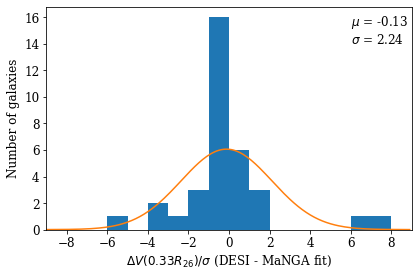

In [51]:
plt.figure(tight_layout=True)

plt.hist(diff_norm, 
         #bins=np.arange(-400, 100, 50), 
         bins=np.arange(-7, 9, 1), 
         #density=True
        )

x = np.arange(-9, 9, 0.1)
plt.plot(x, area*stats.norm.pdf(x, avg, std_dev))

plt.annotate('$\mu$ = {0:.2f}\n$\sigma$ = {1:.2f}'.format(avg, std_dev), 
             (6, 14))

plt.xlim((-9, 9))

#plt.xlabel('$\Delta V(0.33R_{26})$ [km/s] (DESI - MaNGA fit)')
plt.xlabel('$\Delta V(0.33R_{26})/\sigma$ (DESI - MaNGA fit)')
plt.ylabel('Number of galaxies');

#plt.savefig('../Figures/SV/fuji_MaNGA_V0p33_pull.png', dpi=300);

# Compare DESI's observed rotational velocities at $0.33R_{26}$ with the velocity observed in MaNGA

To do this, we need to extract the observed redshifts at the center and at the location of the fiber from the MaNGA H$\alpha$ maps.

In [31]:
MANGA_FOLDER = '/project/projectdirs/sdss/data/sdss/dr16/manga/spectro/'
VEL_MAP_FOLDER = MANGA_FOLDER + 'analysis/v2_4_3/2.2.1/HYB10-GAU-MILESHC/'

hdul = fits.open(VEL_MAP_FOLDER + '7443/12705/manga-7443-12705-MAPS-HYB10-GAU-MILESHC.fits.gz')
vel = hdul['EMLINE_GVEL']
#hdul.close()

In [32]:
axis_0p3_good['V_MaNGA'] = np.nan
axis_0p3_good['V_MaNGA_IVAR'] = np.nan

for i in range(len(axis_0p3_good)):
    
    gal_row = SGA_MaNGA['sga_id'] == axis_0p3_good['SGA_ID'][i]
    
    if np.sum(gal_row) > 0:
        
        # Find galaxy's MaNGA plate-IFU
        gal_plate = SGA_MaNGA['MaNGA_plate'][gal_row][0]
        gal_IFU = SGA_MaNGA['MaNGA_IFU'][gal_row][0]


        ##################################################################################
        # Import data file
        #---------------------------------------------------------------------------------
        file_name = str(gal_plate) + '/' + str(gal_IFU) + '/manga-' + str(gal_plate) + '-' + str(gal_IFU) + '-MAPS-HYB10-GAU-MILESHC.fits.gz'

        if os.path.isfile(VEL_MAP_FOLDER + file_name):
            hdul = fits.open(VEL_MAP_FOLDER + file_name)
            cz = hdul['PRIMARY'].header['SCINPVEL']
            vel = hdul['EMLINE_GVEL']

            Ha_vel = vel.data[18] + cz
            Ha_ivar = hdul['EMLINE_GVEL_IVAR'].data[18]
            Ha_mask = hdul['EMLINE_GVEL_MASK'].data[18]

            mHa_vel = ma.array(Ha_vel, mask=Ha_mask)
            mHa_ivar = ma.array(Ha_ivar, mask=Ha_mask)
            ##################################################################################

            gal_wcs = wcs.WCS(vel.header)
            '''
            ##################################################################################
            plt.figure()

            ax = plt.subplot(projection=gal_wcs, slices=('x', 'y', 18))
            vel_im = ax.imshow(mHa_vel, cmap='RdBu_r', origin='lower')

            plt.plot(axis_0p3_good['RA'][i], axis_0p3_good['DEC'][i], 'gx', transform=ax.get_transform('world'))

            plt.colorbar(vel_im, ax=ax)
            ##################################################################################
            ''';
            # Convert DESI observed coordinates to pixel coordinates
            pix_coords = gal_wcs.wcs_world2pix(np.array([[axis_0p3_good['RA'][i], axis_0p3_good['DEC'][i], 18]]), 0)

            #print(axis_0p3_good['RA'][i], axis_0p3_good['DEC'][i])
            #print(pix_coords, pix_coords[0][:2], pix_coords[0][:2].astype(int))

            # Extract observed velocity at that location
            cz_manga = mHa_vel[pix_coords[0][0].astype(int), pix_coords[0][1].astype(int)]
            cz_manga_ivar = mHa_ivar[pix_coords[0][0].astype(int), pix_coords[0][1].astype(int)]

            #print(cz_manga)

            # Save this measured velocity
            axis_0p3_good['V_MaNGA'][i] = cz_manga
            axis_0p3_good['V_MaNGA_IVAR'][i] = cz_manga_ivar
            '''
            ##################################################################################
            plt.figure()

            plt.imshow(mHa_vel, cmap='RdBu_r', origin='lower')
            plt.plot(pix_coords[0][0], pix_coords[0][1], 'gx')
            ##################################################################################

            break
            ''';

/global/common/software/desi/cori/desiconda/20211217-2.0.0/conda/lib/python3.9/site-packages/astropy/table/column.py:1169: UserWarning: Warning: converting a masked element to nan.
  self.data[index] = value


In [33]:
good_centers['V_MaNGA'] = np.nan
good_centers['V_MaNGA_IVAR'] = np.nan

for i in range(len(good_centers)):
    
    gal_row = SGA_MaNGA['sga_id'] == good_centers['SGA_ID'][i]
    
    if np.sum(gal_row) > 0:
        
        # Find galaxy's MaNGA plate-IFU
        gal_plate = SGA_MaNGA['MaNGA_plate'][gal_row][0]
        gal_IFU = SGA_MaNGA['MaNGA_IFU'][gal_row][0]

        ##################################################################################
        # Import data file
        #---------------------------------------------------------------------------------
        file_name = str(gal_plate) + '/' + str(gal_IFU) + '/manga-' + str(gal_plate) + '-' + str(gal_IFU) + '-MAPS-HYB10-GAU-MILESHC.fits.gz'

        if os.path.isfile(VEL_MAP_FOLDER + file_name):
            hdul = fits.open(VEL_MAP_FOLDER + file_name)
            cz = hdul['PRIMARY'].header['SCINPVEL']
            vel = hdul['EMLINE_GVEL']

            Ha_vel = vel.data[18] + cz
            Ha_ivar = hdul['EMLINE_GVEL_IVAR'].data[18]
            Ha_mask = hdul['EMLINE_GVEL_MASK'].data[18]

            mHa_vel = ma.array(Ha_vel, mask=Ha_mask)
            mHa_ivar = ma.array(Ha_ivar, mask=Ha_mask)
            ##################################################################################

            gal_wcs = wcs.WCS(vel.header)
            
            # Convert DESI observed coordinates to pixel coordinates
            pix_coords = gal_wcs.wcs_world2pix(np.array([[good_centers['RA'][i], 
                                                          good_centers['DEC'][i], 
                                                          18]]), 
                                               0)

            # Extract observed velocity at that location
            cz_manga = mHa_vel[pix_coords[0][0].astype(int), pix_coords[0][1].astype(int)]
            cz_manga_ivar = mHa_ivar[pix_coords[0][0].astype(int), pix_coords[0][1].astype(int)]

            #print(cz_manga)

            # Save this measured velocity
            good_centers['V_MaNGA'][i] = cz_manga
            good_centers['V_MaNGA_IVAR'][i] = cz_manga_ivar

/global/common/software/desi/cori/desiconda/20211217-2.0.0/conda/lib/python3.9/site-packages/astropy/table/column.py:1169: UserWarning: Warning: converting a masked element to nan.
  self.data[index] = value


In [34]:
axis_0p3_good['V_ROT_MaNGA'] = np.nan
axis_0p3_good['V_ROT_MaNGA_ERR'] = np.nan


# For each SGA galaxy that has at least one center observation, calculate the 
# distance for all of that galaxy's targets
for sga_gal in np.unique(good_centers['SGA_ID']):
    
    # Identify all galaxy targets on this galaxy
    obs_idx = axis_0p3_good['SGA_ID'] == sga_gal
    center_idx = good_centers['SGA_ID'] == sga_gal
    
    # Find galaxy index in SGA catalog
    sga_idx = SGA_dict[sga_gal]
    
    
    #---------------------------------------------------------------------------
    # Calculate rotational velocity
    #---------------------------------------------------------------------------
    # Use the average redshift of all center observations for the systemic velocity
    cz_center = np.mean(good_centers['V_MaNGA'][center_idx])
    cz_err_center2 = np.sum(1./good_centers['V_MaNGA_IVAR'][center_idx])/np.sum(center_idx)**2

    # Calculate rotational velocity for all observations of the galaxy
    axis_0p3_good['V_ROT_MaNGA'][obs_idx] = axis_0p3_good['V_MaNGA'][obs_idx] - cz_center
    axis_0p3_good['V_ROT_MaNGA_ERR'][obs_idx] = np.sqrt(1./axis_0p3_good['V_MaNGA_IVAR'][obs_idx] + cz_err_center2)
    #---------------------------------------------------------------------------
    
    
    #---------------------------------------------------------------------------
    # Correct rotational velocities for inclination angle
    #---------------------------------------------------------------------------
    cosi2 = (SGA['BA'][sga_idx]**2 - q0**2)/(1 - q0**2)
    
    # Galaxies with b/a < q0
    if cosi2 < 0:
        cosi2 = 0
    
    axis_0p3_good['V_ROT_MaNGA'][obs_idx] /= np.sin(np.arccos(np.sqrt(cosi2)))
    #---------------------------------------------------------------------------

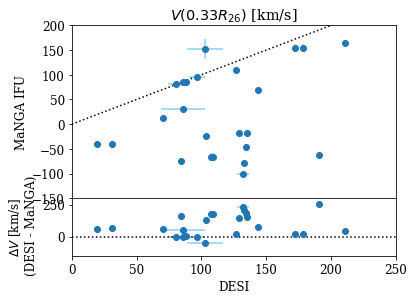

In [35]:
fig = plt.figure()

frame1 = fig.add_axes((0.2, 0.35, 0.75, 0.6))

plt.errorbar(axis_0p3_good['V_ROT'], axis_0p3_good['V_ROT_MaNGA'], 
             yerr=axis_0p3_good['V_ROT_MaNGA_ERR'], 
             xerr=axis_0p3_good['V_ROT_ERR'], 
             fmt='o', 
             ecolor='lightskyblue')
plt.plot([0, 1000], [0, 1000], 'k:')

plt.ylim(-150, 200)
plt.xlim(0, 250)

plt.ylabel('MaNGA IFU')

plt.title('$V(0.33R_{26})$ [km/s]')

frame1.axes.get_xaxis().set_visible(False)


frame2 = fig.add_axes((0.2, 0.15, 0.75, 0.2))

plt.errorbar(axis_0p3_good['V_ROT'], axis_0p3_good['V_ROT'] - axis_0p3_good['V_ROT_MaNGA'], 
             xerr=axis_0p3_good['V_ROT_ERR'], 
             yerr=np.sqrt(axis_0p3_good['V_ROT_ERR']**2 + axis_0p3_good['V_ROT_MaNGA_ERR']**2), 
             fmt='o', 
             ecolor='lightskyblue')
plt.hlines(0, 0, 250, linestyles='dotted', colors='k')

plt.xlim(0, 250)
plt.ylim(-150, 300)

plt.xlabel('DESI')
plt.ylabel('$\Delta V$ [km/s]\n (DESI - MaNGA)');

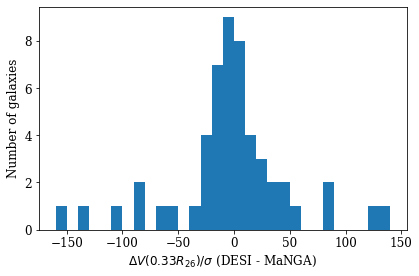

In [36]:
plt.figure(tight_layout=True)

plt.hist((axis_0p3_good['V_ROT'] - axis_0p3_good['V_ROT_MaNGA'])/np.sqrt(axis_0p3_good['V_ROT_ERR']**2 + axis_0p3_good['V_ROT_MaNGA_ERR']**2), 
         #bins=np.arange(-400, 100, 50), 
         bins=np.arange(-160, 150, 10)
        )

#plt.xlabel('$\Delta V(0.33R_{26})$ [km/s] (DESI - MaNGA fit)')
plt.xlabel('$\Delta V(0.33R_{26})/\sigma$ (DESI - MaNGA)')
plt.ylabel('Number of galaxies');